<a href="https://www.kaggle.com/code/nadinejackson1/face-mask-detector?scriptVersionId=128360270" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Import the libraries

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load and preprocess the dataset

data_path = "../input/face-mask-12k-images-dataset/Face Mask Dataset"

def load_images_labels(data_path, folder):
    images = []
    labels = []
    folder_path = os.path.join(data_path, folder)
    
    for label in ['WithMask', 'WithoutMask']:
        label_folder_path = os.path.join(folder_path, label)
        for img_file in os.listdir(label_folder_path):
            img_path = os.path.join(label_folder_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128)) / 255.0
            images.append(img)
            labels.append(0 if label == 'WithMask' else 1)
    
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_labels(data_path, 'Train')
val_images, val_labels = load_images_labels(data_path, 'Validation')
test_images, test_labels = load_images_labels(data_path, 'Test')

In [3]:
# Define the CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [4]:
# Train the model

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    batch_size=32,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
313/313 [==============================] - 16s 20ms/step - loss: 0.1573 - accuracy: 0.9442 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 2/10
313/313 [==============================] - 6s 18ms/step - loss: 0.0653 - accuracy: 0.9763 - val_loss: 0.0164 - val_accuracy: 0.9962
Epoch 3/10
313/313 [==============================] - 6s 18ms/step - loss: 0.0456 - accuracy: 0.9854 - val_loss: 0.0281 - val_accuracy: 0.9912
Epoch 4/10
313/313 [==============================] - 6s 18ms/step - loss: 0.0328 - accuracy: 0.9897 - val_loss: 0.0169 - val_accuracy: 0.9937


In [5]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Generate predictions
pred_labels = np.argmax(model.predict(test_images), axis=1)

# Display confusion matrix and classification report
print(confusion_matrix(test_labels, pred_labels))
print(classification_report(test_labels, pred_labels))


31/31 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.9839
Test accuracy: 98.39%
31/31 [==============================] - 0s 6ms/step
[[477   6]
 [ 10 499]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       483
           1       0.99      0.98      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



In [6]:
# Save the model

model.save('face_mask_detector.h5')

1/1 [==============================] - 0s 141ms/step


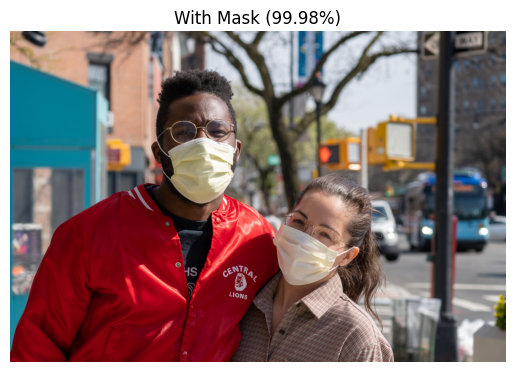

In [7]:
# Load the sample image
sample_img_path = '/kaggle/input/sample-photos/julian-wan-DWaC44FUV5o-unsplash.jpg'
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img_resized = cv2.resize(sample_img, (128, 128)) / 255.0

# Make a prediction on the sample image
pred = model.predict(np.expand_dims(sample_img_resized, axis=0))
label = np.argmax(pred)

# Display the result
label_text = 'With Mask' if label == 0 else 'Without Mask'
confidence = np.max(pred) * 100

plt.imshow(sample_img)
plt.title(f"{label_text} ({confidence:.2f}%)")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 23ms/step


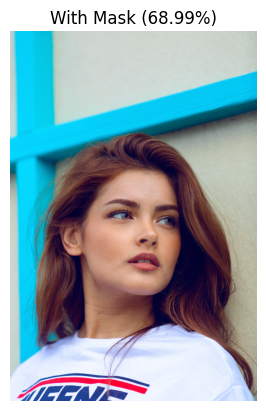

In [8]:
# Load the sample image
sample_img_path = '/kaggle/input/sample-photo2/ayo-ogunseinde-6W4F62sN_yI-unsplash.jpg'
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img_resized = cv2.resize(sample_img, (128, 128)) / 255.0

# Make a prediction on the sample image
pred = model.predict(np.expand_dims(sample_img_resized, axis=0))
label = np.argmax(pred)

# Display the result
label_text = 'With Mask' if label == 0 else 'Without Mask'
confidence = np.max(pred) * 100

plt.imshow(sample_img)
plt.title(f"{label_text} ({confidence:.2f}%)")
plt.axis('off')
plt.show()